In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm
from matplotlib import colors

In [2]:
plt.rcParams["figure.figsize"] = [15.00, 7.50]
plt.rcParams["figure.autolayout"] = True
#plt.rcParams["figure.figsize"] = [30.00, 20.50]
#plt.rcParams["figure.autolayout"] = True

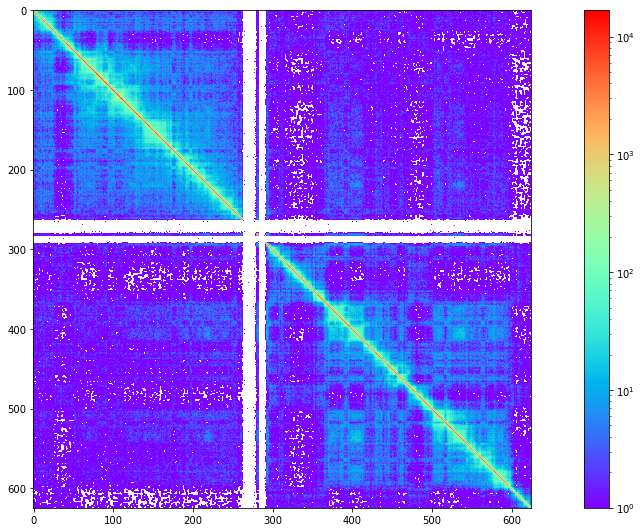

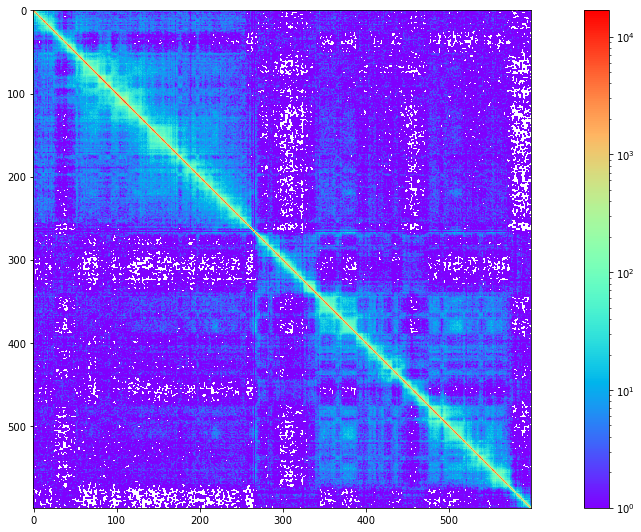

C shape (599, 599)


In [3]:
path = '..//data//IMR90_100kb_chr20.csv'
C = np.array(pd.read_csv(f'{path}', header=None))

im = plt.imshow(C, cmap=cm.rainbow, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

mask = (C == 0).all(0)
# Find the indices of these columns
index = np.where(~mask)[0]
C = C[~mask,:]
C = C[:,~mask]


im = plt.imshow(C, cmap=cm.rainbow, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

print('C shape', C.shape)

In [4]:
def extract_block_diag(A,M,k=0):
    """Extracts blocks of size M from the kth diagonal 
    of square matrix A, whose size must be a multiple of M.
    
    (k=0 - the main diagnoal)
    
    """

    # Check that the matrix can be block divided. If it is not, cut the matrix into 2 blocks such that the first block is divided into M blocks and the last one remains as it is
    rem_ = None
    if A.shape[0] != A.shape[1] or A.shape[0] % M != 0:
        rem_ = []
        remainder_block = A[-(A.shape[0] % M):, -(A.shape[0] % M):]   
        rem_.append([remainder_block, [A.shape[0]-(A.shape[0] % M), A.shape[0]-(A.shape[0] % M)], [A.shape[0], A.shape[0]]])

        A = A[:-(A.shape[0] % M), :-(A.shape[0] % M)]

    # Assign indices for offset from main diagonal
    if abs(k) > M - 1:
        raise ValueError('kth diagonal does not exist in matrix')
    elif k > 0:
        ro = 0
        co = abs(k)*M 
    elif k < 0:
        ro = abs(k)*M
        co = 0
    else:
        ro = 0
        co = 0
    def get_block(A, i, ro, M, co):
        c1_left_x = i+ro
        c1_left_y = i+co

        c2_right_x = i+ro+M
        c2_right_y = i+co+M
        return [A[i+ro:i+ro+M,i+co:i+co+M], [c1_left_x,  c1_left_y], [c2_right_x, c2_right_y]]
    blocks = [get_block(A, i, ro, M, co)
                       for i in range(0,len(A)-abs(k)*M,M)]
    if rem_ is not None:
        blocks.extend(rem_)
    return blocks

### 

In [5]:
# visual test

#print('np.diag', [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, C.shape[0])][:5])
#print('----')
#print('extract block', extract_block_diag(C, 1)[:5])
#print('\n----reverse----\n')
#print('np.diag', [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, C.shape[0])][-5:])
#print('----')
#print('extract block', extract_block_diag(C, 1)[-5:])

In [6]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def merge_clusters(C, clusters, i1, i2):
    '''
    Input:
    C: contact matrix (np.array)
    clusters: list of currents clusters
    i1: index representing i1-th cluster in 'clusters'
    i2: index representing i2-th cluster in 'clusters'
    Output:
    A list of length 3, where:
    the 1st element is the resulting cluster (block); dtype = np.array
    the 2d element is the upper left coordinate of the block; dtype = (x, y)
    the 3d element is the lower right coordinate of the block; dtype = (x, y)
    '''
    assert i2 - i1 == 1
    c1 = clusters[i1]
    c2 = clusters[i2]

    c1_left_x = c1[1][0]
    c1_left_y = c1[1][1]
    c2_right_x = c2[2][0]
    c2_right_y = c2[2][1]
    return [C[c1_left_x:c2_right_x, c1_left_y:c2_right_y], [c1_left_x,  c1_left_y], [c2_right_x, c2_right_y]] # [C[c1_left_x:c2_right_x+1, c1_left_y:c2_right_y+1], [c1_left_x,  c1_left_y], [c2_right_x+1, c2_right_y+1]]

def get_cluster(u, u_t, C, clusters):
    if u < u_t:
        return clusters[u]
    if u == u_t:
        return merge_clusters(C, clusters, u, u+1)
    if u > u_t:
        return clusters[u+1]
def clusterize(C, depth, initial_cluster_size, measure, criterion,  color_norm):
    C = C.copy()
    np.fill_diagonal(C, 0)
    clusters = []
    clusters = extract_block_diag(C, initial_cluster_size) # alternative, but not recommended: [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, p)]
    p = len(clusters)
    print('initial depth:')
    for t in range(0, p):
        u_t = criterion([measure(
        merge_clusters(C, clusters, u, u+1),
        clusters[u],
        clusters[u+1]) for u in range(0, p - t - 1)])
        clusters = [get_cluster(u, u_t, C, clusters) for u in range(0, p-t-1)]
        if len(clusters) == depth:
            break
    
    
    # Plotting

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(C, cmap=cm.rainbow, norm = color_norm)

    for cluster in clusters:
        rect = patches.Rectangle(cluster[1], cluster[2][0]-cluster[1][0], cluster[2][1]-cluster[1][0], linewidth=6, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()
    return clusters

C:\Users\user\AppData\Local\Temp\ipykernel_1804\1590897164.py:9: RuntimeWarning: divide by zero encountered in divide
  inverse_C = 1/C


initial depth:


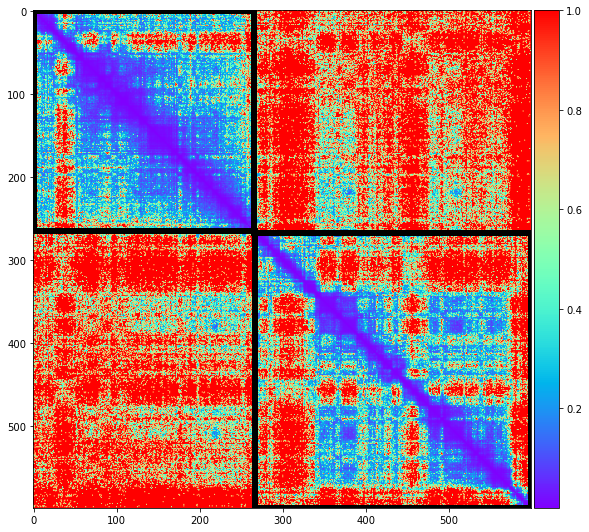

In [17]:
m = 599
inverse = True
depth = 3
use_log = True
initial_cluster_size = 1
if inverse:
    def measure(merged_clusters, c1, c2):
        return -(np.mean(merged_clusters[0]) - np.mean(c1[0]) - np.mean(c2[0]))
    inverse_C = 1/C
    inverse_C[inverse_C == np.inf] = 1
    clusters = clusterize(inverse_C [:m, :m], 
             depth = depth,
             initial_cluster_size = initial_cluster_size,
             measure = measure,
             criterion = np.argmin,
             color_norm= colors.Normalize(inverse_C.min(), inverse_C.max()))
else:
    def measure(merged_clusters, c1, c2):
        return np.mean(merged_clusters[0]) - np.mean(c1[0]) - np.mean(c2[0])
    if use_log:
        log_data = np.log(C)
        log_data[log_data == -np.inf] = 0.0
        clusters = clusterize(log_data[:m, :m], 
                depth = depth,
                initial_cluster_size = initial_cluster_size,
                measure = measure,
                criterion = np.argmax,
                color_norm= colors.LogNorm())
    else:
        clusters = clusterize(C[:m, :m], 
                depth = depth,
                initial_cluster_size = initial_cluster_size,
                measure = measure,
                criterion = np.argmax,
                color_norm= colors.LogNorm())

